# Connect Azure

In [1]:
from azure.storage.blob import BlobServiceClient

# Your Azure Blob Storage account name and account key
account_name = 'ilab9788543873'
account_key = 'TAyrrfaiCQ86vkgSXyStufowrMVdk4T45mVw6TNcFFJocR6pTXy6ZMSUUTeeh5FpNTsBVAbVqdwk+AStHA3x1g=='

# Connect to your Blob Storage account
blob_service_client = BlobServiceClient(account_url=f"https://ilab9788543873.blob.core.windows.net", credential=account_key)

# Name of the container you want to access
container_name = 'azureml'
container_client = blob_service_client.get_container_client(container_name)

# List all blobs (files) in the container
blobs = container_client.list_blobs()
for blob in blobs:
    print(blob.name)


10k_lens.json
ComputeRecord/dcid.bceb8578-0ea6-4a32-818a-08e431d48e79/compute_record.txt
ExperimentRun/dcid.bceb8578-0ea6-4a32-818a-08e431d48e79/logs/azureml/driver
ExperimentRun/dcid.bceb8578-0ea6-4a32-818a-08e431d48e79/logs/azureml/driver/stderr
ExperimentRun/dcid.bceb8578-0ea6-4a32-818a-08e431d48e79/logs/azureml/driver/stdout
ExperimentRun/dcid.bceb8578-0ea6-4a32-818a-08e431d48e79/logs/azureml/librarymanager/vm-92238893.log
ExperimentRun/dcid.bceb8578-0ea6-4a32-818a-08e431d48e79/logs/azureml/librarymanager/vm-e5612677.log
ExperimentRun/dcid.bceb8578-0ea6-4a32-818a-08e431d48e79/logs/azureml/librarymanager/vm-e8544025.log
ExperimentRun/dcid.bceb8578-0ea6-4a32-818a-08e431d48e79/logs/azureml/livy
output.json


Download data from Azure

In [2]:
import json
from azure.storage.blob import BlobServiceClient

container_name = 'azureml'
blob_name = '10k_lens.json'

blob_service_client = BlobServiceClient(account_url=f"https://{account_name}.blob.core.windows.net", credential=account_key)

# Assuming you've already connected to the blob service client and container client
blob_client = container_client.get_blob_client(blob=blob_name)

# Try to download the blob content
try:
    downloaded_blob = blob_client.download_blob()
    data = downloaded_blob.readall()
    data_str = data.decode('utf-8')
    print("Blob content:", data_str[:1000])  # Print the first 1000 characters of the blob
except Exception as e:
    print("Error occurred:", e)



Blob content: [{"lens_id": "188-042-825-946-495", "jurisdiction": "US", "doc_number": "20230284427", "kind": "A1", "date_published": "2023-09-07", "lang": "en", "biblio": {"publication_reference": {"jurisdiction": "US", "doc_number": "20230284427", "kind": "A1", "date": "2023-09-07"}, "application_reference": {"jurisdiction": "US", "doc_number": "17686241", "date": "2022-03-03"}, "priority_claims": {}, "invention_title": [{"text": "SRAM WITH P-TYPE ACCESS TRANSISTORS AND COMPLEMENTARY FIELD-EFFECT TRANSISTOR TECHNOLOGY"}], "parties": {"applicants": [{"extracted_name": {"value": "Intel Corporation"}}], "inventors": [{"extracted_name": {"value": "Charles AUGUSTINE"}}, {"extracted_name": {"value": "Seenivasan SUBRAMANIAM"}}, {"extracted_name": {"value": "Patrick MORROW"}}, {"extracted_name": {"value": "Muhammad M. KHELLAH"}}]}, "classifications_cpc": {"classifications": [{"symbol": "H01L27/1104"}, {"symbol": "G11C11/412"}, {"symbol": "G11C11/419"}]}, "cited_by": {}}, "legal_status": {"pat

# Convert json to dataframe

In [65]:
import pandas as pd

file_path = 'C:/Users/justi/ilab2/ilab/raw_output.json'
df = pd.read_json(file_path)

# To view the first few rows of the dataframe
#print(df.head())


KeyboardInterrupt: 

In [4]:
import pandas as pd
import json

# Convert the JSON string to a list of dictionaries
data_list = json.loads(data_json)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_list)

# Display the first row
print(df.iloc[0])

# Identify columns with nested data
nested_cols = [col for col in df.columns if isinstance(df[col].iloc[0], (dict, list))]
print("\nNested columns:", nested_cols)


TypeError: the JSON object must be str, bytes or bytearray, not list

In [15]:
def unnest_dataframe(df):
    """
    Recursively unnest columns with dictionary type until no more such columns exist.
    """
    while any(df[col].apply(lambda x: isinstance(x, dict)).any() for col in df):
        for column in df.columns:
            if df[column].apply(lambda x: isinstance(x, dict)).any():
                # Unnest the column
                temp_df = df[column].apply(pd.Series)
                temp_df.columns = [f"{column}_{subcol}" for subcol in temp_df.columns]
                
                # Drop the original column and concat the new columns
                df = df.drop(column, axis=1)
                df = pd.concat([df, temp_df], axis=1)
                
    return df

# Apply the function to the DataFrame
df = unnest_dataframe(df)


In [142]:
# Display the first row again to see the changes
print(df.iloc[0])

lens_id                                                                     188-042-825-946-495
jurisdiction                                                                                 US
doc_number                                                                          20230284427
kind                                                                                         A1
date_published                                                                       2023-09-07
lang                                                                                         en
abstract                                      [{'text': 'Embodiments herein relate to scalin...
claims                                        [{'claims': [{'claim_text': ['1 . An apparatus...
biblio_invention_title                        [{'text': 'SRAM WITH P-TYPE ACCESS TRANSISTORS...
legal_status_patent_status                                                              UNKNOWN
legal_status_granted                    

In [16]:
# Define a function to concatenate all texts from a list of dictionaries with 'text' key
def concatenate_texts_from_list(data):
    texts = []
    if isinstance(data, list):
        for item in data:
            if isinstance(item, dict) and 'text' in item:
                texts.append(item['text'])
    return ' '.join(texts)

# Identify columns with lists that contain dictionaries with a 'text' key
columns_with_text_list = ['abstract', 'biblio_invention_title']

# Concatenate texts for the identified columns
for col in columns_with_text_list:
    new_col_name = f"{col}_text"
    df[new_col_name] = df[col].apply(concatenate_texts_from_list)

# For 'claims' column, extract all claim texts and concatenate them
def concatenate_all_claim_texts(claims):
    claim_texts = []
    if isinstance(claims, list):
        for claim in claims:
            if isinstance(claim, dict) and 'claims' in claim:
                for sub_claim in claim['claims']:
                    if isinstance(sub_claim, dict) and 'claim_text' in sub_claim:
                        claim_texts.extend(sub_claim['claim_text'])
    return ' '.join(claim_texts)

df['all_claim_texts'] = df['claims'].apply(concatenate_all_claim_texts)


In [17]:
# Define a function to extract 'value' from 'extracted_name' key in a list of dictionaries
def extract_values_from_extracted_name(data):
    values = []
    if isinstance(data, list):
        for item in data:
            if isinstance(item, dict) and 'extracted_name' in item and 'value' in item['extracted_name']:
                values.append(item['extracted_name']['value'])
    return ', '.join(values)

# List of columns to apply the above function
cols_to_extract = ['biblio_parties_applicants', 'biblio_parties_inventors']

# Apply the function to the columns
for col in cols_to_extract:
    new_col_name = f"{col}_names"
    df[new_col_name] = df[col].apply(extract_values_from_extracted_name)


In [18]:
# Extract 'symbol' values from each dictionary in the list and join them into a single string
df['biblio_classifications_cpc_symbols'] = df['biblio_classifications_cpc_classifications'].apply(lambda x: ', '.join([i['symbol'] for i in x]) if isinstance(x, list) else None)

In [19]:
# List of columns to drop
cols_to_drop = ['abstract', 'claims', 'biblio_invention_title', 'biblio_parties_applicants', 'biblio_parties_inventors', 'biblio_classifications_cpc_classifications']

# Drop columns
df = df.drop(columns=cols_to_drop, errors='ignore')


In [20]:
# Display the first row again to see the changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12944 entries, 0 to 12943
Data columns (total 39 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   lens_id                                     12944 non-null  object        
 1   jurisdiction                                12944 non-null  object        
 2   doc_number                                  12944 non-null  object        
 3   kind                                        12944 non-null  object        
 4   date_published                              12944 non-null  datetime64[ns]
 5   lang                                        12944 non-null  object        
 6   year_month                                  12944 non-null  object        
 7   legal_status_granted                        7670 non-null   object        
 8   legal_status_grant_date                     7605 non-null   object        
 9   legal_

# Data Cleaning

0. Making a copy of the df

In [66]:
df_clean = df

1. Convert Data Types
Convert date_published, biblio_publication_reference.date, and biblio_application_reference.date to datetime data type.

In [67]:
# Convert columns with dates to datetime data type and extract only the date component
date_columns = ['date_published', 'legal_status_grant_date', 'biblio_publication_reference_date', 'biblio_application_reference_date' 'biblio_priority_claims_earliest_claim_date']
for col in date_columns:
    if col in df_clean.columns:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce').dt.date


2. Filter lang to 'en'

In [68]:
# Filter rows where 'lang' is 'en'
df_clean = df_clean[df_clean['lang'] == 'en']


3. Handle Missing Values
In this dataset, we might not want to drop all rows with missing values since that could significantly reduce our data. Instead, for columns like abstract, description_text, and other text fields, we can replace NaNs with empty strings. For other columns, we'll make decisions based on the column's significance.

In [69]:
# Calculate the percentage of missing values for each column
missing_percent = df_clean.isnull().mean() * 100

# Drop columns with more than 80% missing values
cols_to_drop = missing_percent[missing_percent > 80].index.tolist()
df_clean.drop(columns=cols_to_drop, inplace=True)


4. Text normalisation

In [70]:
# Trim whitespace from text columns
text_columns = ['abstract_text', 'all_claim_texts', 'biblio_invention_title_text', 'description_text', 'biblio_parties_inventors_names']
for col in text_columns:
    df_clean[col] = df_clean[col].str.strip()
    
# Convert text columns to lowercase
for col in text_columns:
    df_clean[col] = df_clean[col].str.lower()


In [71]:
df_clean.reset_index(drop=True, inplace=True)


# 1. Keyword analysis

Remove punctuation and numbers

In [16]:
import string

text_columns = ['abstract_text', 'all_claim_texts', 'biblio_invention_title_text', 'description_text']

def remove_punctuation_and_numbers(text):
    if not isinstance(text, str):  # Check if the input is a string
        return text  # If not, return the input as it is
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = ''.join([i for i in text if not i.isdigit()])
    return text


for col in text_columns:
    df_clean[col] = df_clean[col].apply(remove_punctuation_and_numbers)


C:\Users\justi\AppData\Local\Temp\ipykernel_45136\75208684.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = df_clean[col].apply(remove_punctuation_and_numbers)
C:\Users\justi\AppData\Local\Temp\ipykernel_45136\75208684.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = df_clean[col].apply(remove_punctuation_and_numbers)
C:\Users\justi\AppData\Local\Temp\ipykernel_45136\75208684.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

Remove stopwords

In [17]:
pd.options.mode.chained_assignment = None  # default='warn'

In [18]:
from nltk.corpus import stopwords

# Define the stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    # Ensure the text is a string
    text = str(text)
    return ' '.join([word for word in text.split() if word not in stop_words])

# Apply the function to each text column
for col in text_columns:
    # Fill NaN with empty string
    df_clean[col] = df_clean[col].fillna('')
    df_clean[col] = df_clean[col].apply(remove_stopwords)


Stemming/Lemmatization

In [19]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

for col in text_columns:
    df_clean[col] = df_clean[col].apply(lemmatize_text)


Keyword extraction (TF-IDF, N-gram)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(2, 3))

# For simplicity, let's consider the 'abstract_text' column for keyword extraction
tfidf_matrix = vectorizer.fit_transform(df_clean['abstract_text'])

# Get feature names (keywords/phrases)
feature_names = vectorizer.get_feature_names_out()

def get_top_keywords(tfidf_matrix, feature_names, n=10):
    '''Get top n keywords for each document in the matrix.'''
    keywords_list = []
    dense_matrix = tfidf_matrix.todense()
    for doc in dense_matrix:
        sorted_indices = np.argsort(doc)
        top_indices = sorted_indices[0, -n:]
        keywords = [feature_names[i] for i in top_indices[0, ::-1].tolist()[0]]
        keywords_list.append(keywords)
    return keywords_list

df_clean['top_keywords'] = get_top_keywords(tfidf_matrix, feature_names)



In [22]:
df_clean['top_keywords']

0       [word line, access memory, random access memor...
1       [communication technology, équipement utilisat...
2       [electric machine, first portion, method inclu...
3       [technology de, de technology, de information,...
4       [invention discloses, équipement utilisateur, ...
                              ...                        
2269    [équipement utilisateur, disclosure enables va...
2270    [second set, data second, comprising first, sy...
2271    [accelerator device, logic unit, device commun...
2272    [le second, technology system, computer progra...
2273    [de la, par le, de surveillance de, surveillan...
Name: top_keywords, Length: 2274, dtype: object

Topic modelling

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

df_clean['concatenated_text'] = df_clean['description_text'].fillna('') + ' ' + df_clean['abstract_text'].fillna('') + ' ' + df_clean['biblio_invention_title_text'].fillna('') + ' ' + df_clean['all_claim_texts'].fillna('')

# Create a vectorizer instance
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
data_vectorized = vectorizer.fit_transform(df_clean['concatenated_text'])


In [24]:
from sklearn.decomposition import LatentDirichletAllocation

# 2. Apply LDA
num_topics = 10  # You can change this number based on your requirements
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(data_vectorized)

LatentDirichletAllocation(random_state=42)

In [25]:
# 3. Display the top words for each topic
def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

feature_names = vectorizer.get_feature_names_out()
print_top_words(lda_model, feature_names)

Topic #0: application light embodiment material example voltage present surface invention current
Topic #1: signal example ue second communication rat radio wireless station antenna
Topic #2: patent data mtu period example unit computer invention fig application
Topic #3: layer second fig embodiment example region structure surface material portion
Topic #4: embodiment acid compound example comprises group independently product andor agent
Topic #5: data network embodiment node example device application service andor storage
Topic #6: cell sequence fig power flow id method temperature heat embodiment
Topic #7: data device sensor model example image embodiment fig patient user
Topic #8: user data device example andor information service embodiment transaction fig
Topic #9: device example memory data embodiment network includes computing controller processor


In [188]:
''' 
Topic #0: Seems to revolve around materials and electrical properties. Keywords like "light", "voltage", "material", and "surface" hint at inventions related to materials science or electronics.
Topic #1: Clearly related to communications technology. Keywords like "signal", "communication", "radio", "wireless", and "antenna" point towards innovations in telecommunications, possibly mobile communication given the presence of "ue" (User Equipment) and "rat" (Radio Access Technology).
Topic #2: This topic seems to be about computer systems and data processing. Keywords like "data", "mtu" (Maximum Transmission Unit), "computer", and "fig" (figure) hint at systems or methods for processing or transmitting data.
Topic #3: This is related to structures and materials. Keywords like "layer", "region", "structure", and "portion" suggest inventions in the realm of material structures, possibly in nanotechnology or semiconductor designs.
Topic #4: Appears to be related to chemistry or pharmaceuticals. Words like "acid", "compound", "group", and "agent" suggest this could be about chemical compounds or drug formulations.
Topic #5: Concerns networking and data storage. "Network", "node", "data", "service", and "storage" are clear indicators of inventions in the realm of IT infrastructure or cloud services.
Topic #6: This might be about energy and thermodynamics. "Power", "flow", "temperature", and "heat" are indicative of inventions related to energy production or thermal management.
Topic #7: This seems to be related to medical or imaging devices. Keywords like "sensor", "model", "image", and "patient" hint at medical equipment or imaging technology.
Topic #8: This is about user-centric services and devices. "User", "information", "service", and "transaction" suggest this might be about e-commerce, online services, or user-interface innovations.
Topic #9: This seems to focus on computing devices and systems. "Device", "memory", "network", "computing", and "controller" point towards hardware or system-level innovations.
'''

' \nTopic #0: Seems to revolve around materials and electrical properties. Keywords like "light", "voltage", "material", and "surface" hint at inventions related to materials science or electronics.\nTopic #1: Clearly related to communications technology. Keywords like "signal", "communication", "radio", "wireless", and "antenna" point towards innovations in telecommunications, possibly mobile communication given the presence of "ue" (User Equipment) and "rat" (Radio Access Technology).\nTopic #2: This topic seems to be about computer systems and data processing. Keywords like "data", "mtu" (Maximum Transmission Unit), "computer", and "fig" (figure) hint at systems or methods for processing or transmitting data.\nTopic #3: This is related to structures and materials. Keywords like "layer", "region", "structure", and "portion" suggest inventions in the realm of material structures, possibly in nanotechnology or semiconductor designs.\nTopic #4: Appears to be related to chemistry or phar

In [33]:
# Get the topic distribution for documents
doc_topic_dist = lda_model.transform(data_vectorized)

# Assign dominant topic for each document
df_clean['dominant_topic'] = doc_topic_dist.argmax(axis=1)

# Define a dictionary to map topic numbers to topic names
topic_names = {
    0: 'Materials & Electronics',
    1: 'Communications Technology',
    2: 'Data Processing',
    3: 'Material Structures',
    4: 'Chemistry & Pharmaceuticals',
    5: 'IT Infrastructure',
    6: 'Energy & Thermodynamics',
    7: 'Medical Imaging',
    8: 'E-commerce & User Services',
    9: 'Computing Systems'
}

# Replace the values in 'dominant_topic' using the topic_names dictionary
df_clean['dominant_topic'] = df_clean['dominant_topic'].replace(topic_names)


# Temporal Analysis

In [6]:
df_clean = df

In [7]:
# Convert the 'date_published' column to datetime format
df_clean['date_published'] = pd.to_datetime(df_clean['date_published'])

# Create a 'year_month' column in the format 'YYYY-MM'
df_clean['year_month'] = df_clean['date_published'].dt.strftime('%Y-%m')

# Group by year and dominant topic
topic_counts = df_clean.groupby(['year_month', 'dominant_topic']).size().reset_index(name='counts')



KeyError: 'dominant_topic'

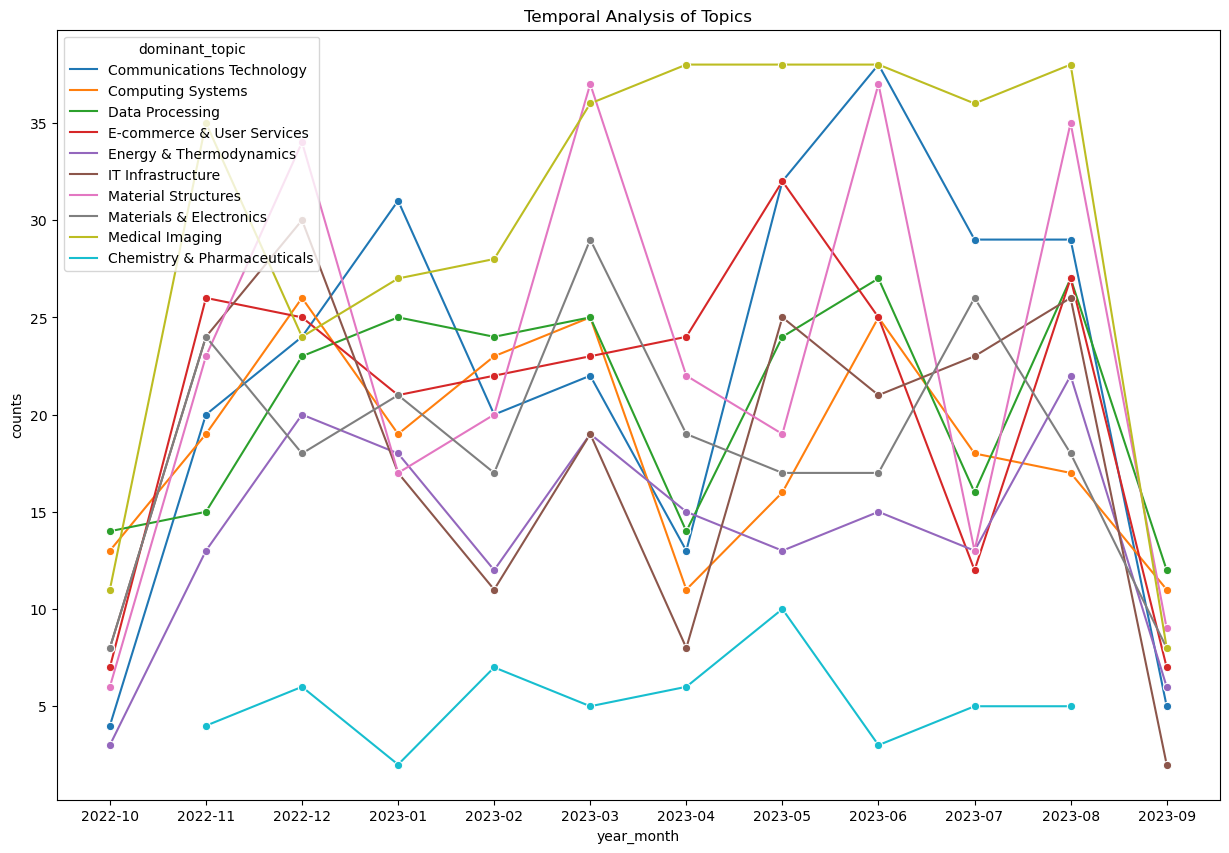

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,10))
sns.lineplot(data=topic_counts, x='year_month', y='counts', hue='dominant_topic', marker='o')
plt.title('Temporal Analysis of Topics')
plt.show()


# Associative Analysis

Preprocessing

In [36]:
# Convert the 'top_keywords' column into a list of lists
transactions = df_clean['top_keywords'].tolist()


Applying the Apriori Algorithm and Generating Association Rules

In [37]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Encode the transactions into a one-hot encoded DataFrame
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

# Generate frequent itemsets
frequent_itemsets = apriori(df_transactions, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values('confidence', ascending=False, inplace=True)


In [38]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
51741,"(disclosure enables various, données de, équip...","(dlt network, dispositif électronique, distrib...",0.237467,0.345207,0.237467,1.000000,2.896815,0.155492,inf,0.858708
62553,"(dlt network, disclosure enables various, disp...",(divulgation concerne),0.224714,0.439754,0.224714,1.000000,2.274000,0.125895,inf,0.722632
62557,"(dlt network, disclosure enables various, équi...",(dispositif électronique),0.224714,0.438874,0.224714,1.000000,2.278557,0.126093,inf,0.723766
62559,"(disclosure enables various, dispositif électr...",(dlt network),0.224714,0.408971,0.224714,1.000000,2.445161,0.132813,inf,0.762337
62560,"(dlt network, disclosure enables various, disp...","(distributed ledger, divulgation concerne)",0.224714,0.401935,0.224714,1.000000,2.487965,0.134394,inf,0.771412
...,...,...,...,...,...,...,...,...,...,...
1603,(distributed ledger),"(dlt network, present disclosure)",0.448989,0.010994,0.010114,0.022527,2.049050,0.005178,1.011799,0.929144
272,(distributed ledger),"(dispositif électronique, disclosed one embodi...",0.448989,0.010994,0.010114,0.022527,2.049050,0.005178,1.011799,0.929144
17993,(distributed ledger),"(present invention, dispositif électronique, é...",0.448989,0.010114,0.010114,0.022527,2.227228,0.005573,1.012699,1.000000
6261,(distributed ledger),"(dispositif électronique, équipement utilisate...",0.448989,0.010554,0.010114,0.022527,2.134427,0.005376,1.012249,0.964572


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a pivot table of support and confidence
heatmap_data = rules.pivot(index='support', columns='confidence', values='lift')

# Plotting the heatmap
plt.figure(figsize=(12,8))
sns.scatterplot(data=rules, x='confidence', y='support', hue='lift', palette='YlGnBu', size='lift', sizes=(10,200))
plt.title('Scatter Plot of Support vs Confidence with Lift as Size')
plt.legend(loc='upper right')
plt.show()



ValueError: Index contains duplicate entries, cannot reshape

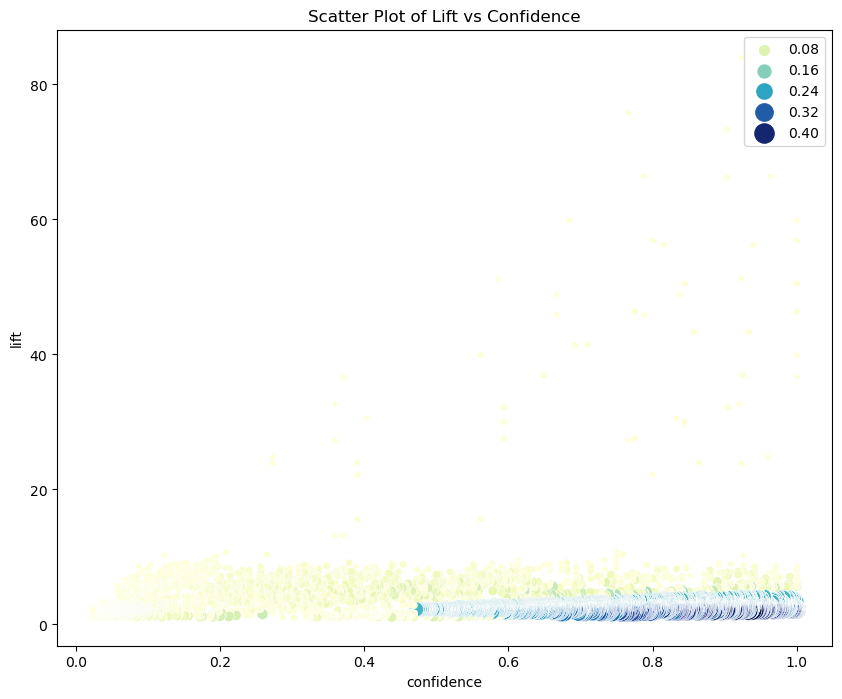

In [41]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=rules, x='confidence', y='lift', hue='support', palette='YlGnBu', size='support', sizes=(20,200))
plt.title('Scatter Plot of Lift vs Confidence')
plt.legend(loc='upper right')
plt.show()


# Jurisdiction by location

In [30]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12944 entries, 0 to 12943
Data columns (total 33 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   lens_id                                     12944 non-null  object 
 1   jurisdiction                                12944 non-null  object 
 2   doc_number                                  12944 non-null  object 
 3   kind                                        12944 non-null  object 
 4   date_published                              12944 non-null  object 
 5   lang                                        12944 non-null  object 
 6   year_month                                  12944 non-null  object 
 7   legal_status_granted                        7670 non-null   object 
 8   legal_status_grant_date                     7605 non-null   object 
 9   legal_status_patent_status                  12944 non-null  object 
 10  descriptio

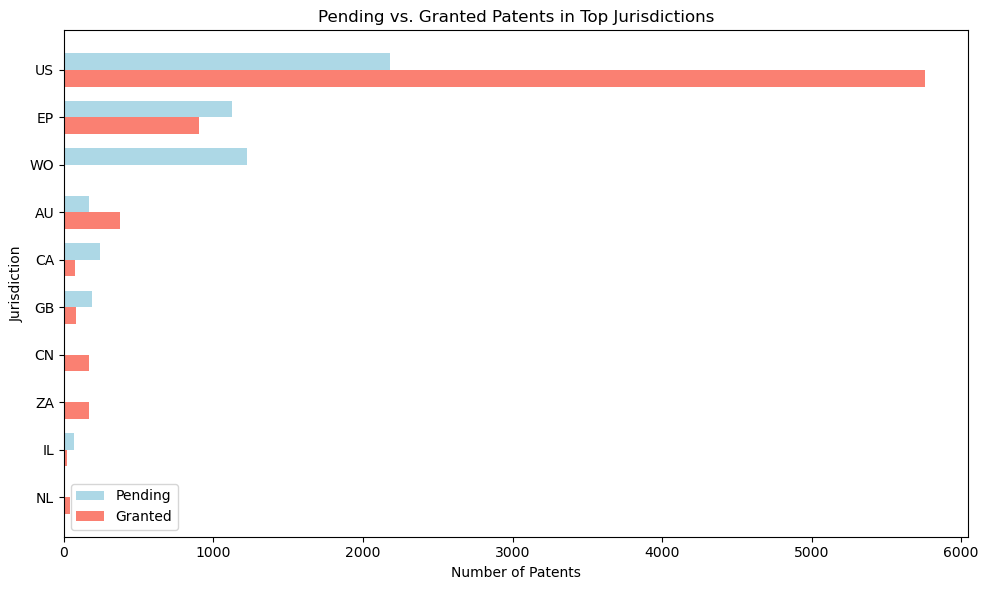

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter datasets for 'pending' and 'granted' patents
pending = df_clean[df_clean['legal_status_granted'].isnull()]
granted = df_clean[df_clean['legal_status_granted'].notnull()]

# Get the top 10 jurisdictions from the whole dataset
top_jurisdictions = df_clean['jurisdiction'].value_counts().head(10).index

# Count patents for the top jurisdictions
pending_counts = pending['jurisdiction'].value_counts().reindex(top_jurisdictions, fill_value=0)
granted_counts = granted['jurisdiction'].value_counts().reindex(top_jurisdictions, fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
ind = range(len(top_jurisdictions))

p1 = ax.barh(ind, pending_counts, width, label='Pending', color='lightblue')
p2 = ax.barh([i + width for i in ind], granted_counts, width, label='Granted', color='salmon')

ax.set_title('Pending vs. Granted Patents in Top Jurisdictions')
ax.set_xlabel('Number of Patents')
ax.set_ylabel('Jurisdiction')
ax.set_yticks([i + width/2 for i in ind])
ax.set_yticklabels(top_jurisdictions)
ax.legend()

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Application analysis

Top Applicants

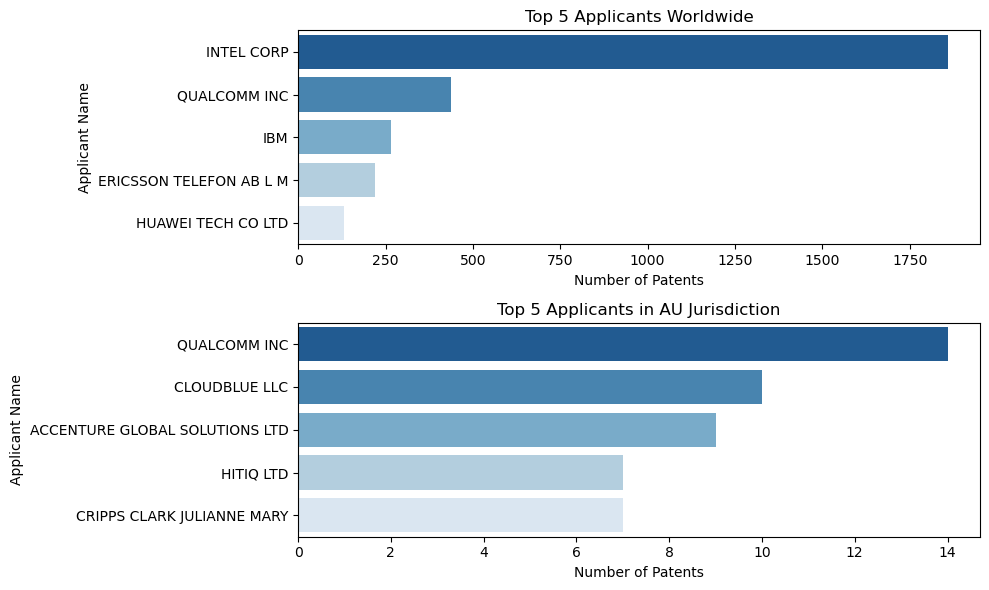

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Top 5 applicants based on total patents
top_applicants = df_clean['biblio_parties_applicants_names'].value_counts().head(5)

# 2. Top 5 applicants within 'AU' jurisdiction
au_applicants = df_clean[df_clean['jurisdiction'] == 'AU']
top_au_applicants = au_applicants['biblio_parties_applicants_names'].value_counts().head(5)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))  # Adjusted height to 6

sns.barplot(x=top_applicants.values, y=top_applicants.index, ax=axes[0], palette="Blues_r")
axes[0].set_title('Top 5 Applicants Worldwide')
axes[0].set_xlabel('Number of Patents')
axes[0].set_ylabel('Applicant Name')

sns.barplot(x=top_au_applicants.values, y=top_au_applicants.index, ax=axes[1], palette="Blues_r")
axes[1].set_title('Top 5 Applicants in AU Jurisdiction')
axes[1].set_xlabel('Number of Patents')
axes[1].set_ylabel('Applicant Name')

plt.tight_layout()
plt.show()


# Legal status analysis

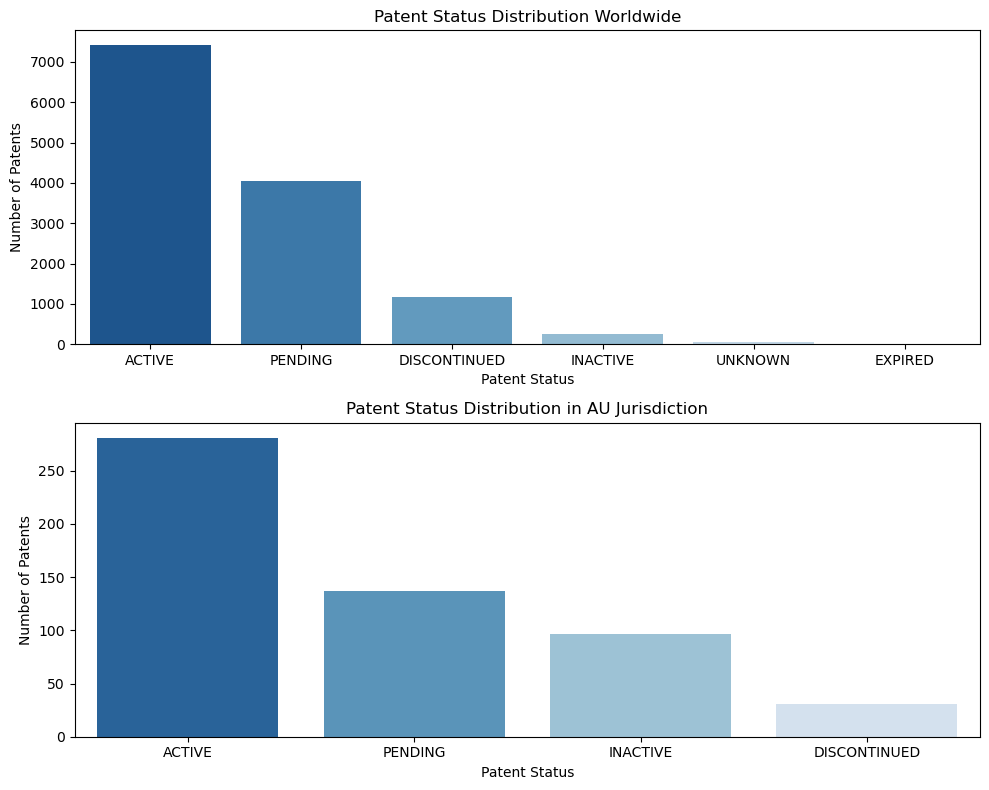

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Patent status distribution for the entire dataset
overall_status = df_clean['legal_status_patent_status'].value_counts()

# 2. Patent status distribution for 'AU' jurisdiction
au_status = df_clean[df_clean['jurisdiction'] == 'AU']['legal_status_patent_status'].value_counts()

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

sns.barplot(x=overall_status.index, y=overall_status.values, ax=axes[0], palette="Blues_r")
axes[0].set_title('Patent Status Distribution Worldwide')
axes[0].set_xlabel('Patent Status')
axes[0].set_ylabel('Number of Patents')

sns.barplot(x=au_status.index, y=au_status.values, ax=axes[1], palette="Blues_r")
axes[1].set_title('Patent Status Distribution in AU Jurisdiction')
axes[1].set_xlabel('Patent Status')
axes[1].set_ylabel('Number of Patents')

plt.tight_layout()
plt.show()


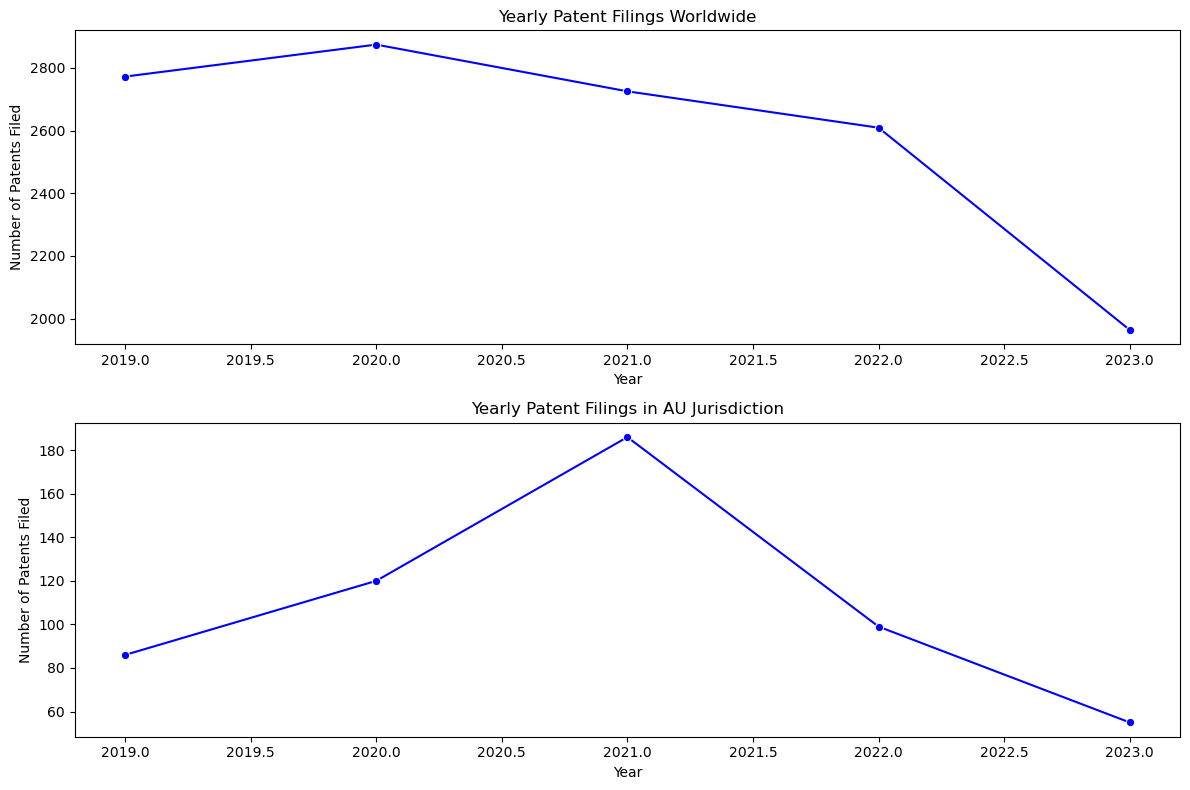

In [38]:
# Convert the 'date_published' column to datetime
df_clean['date_published'] = pd.to_datetime(df_clean['date_published'])

# Extract the year from the 'date_published' column
df_clean['year'] = df_clean['date_published'].dt.year

# Continue with the code as before...

# Continue with the code as before...

# 1. Yearly patent filings for the entire dataset
overall_yearly = df_clean.groupby('year').size()

# 2. Yearly patent filings for 'AU' jurisdiction
au_yearly = df_clean[df_clean['jurisdiction'] == 'AU'].groupby('year').size()

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

sns.lineplot(x=overall_yearly.index, y=overall_yearly.values, ax=axes[0], marker='o', color='blue')
axes[0].set_title('Yearly Patent Filings Worldwide')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Patents Filed')

sns.lineplot(x=au_yearly.index, y=au_yearly.values, ax=axes[1], marker='o', color='blue')
axes[1].set_title('Yearly Patent Filings in AU Jurisdiction')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of Patents Filed')

plt.tight_layout()
plt.show()


# 1

In [63]:
import pandas as pd

file_path = 'C:/Users/justi/ilab2/ilab/cpc_mapping.csv'
cpc = pd.read_csv(file_path)

# To view the first few rows of the dataframe
print(cpc.head())


  Subsymbol                                        Description
0         A                                  HUMAN NECESSITIES
1       A01  AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTI...
2       A21                              BAKING; EDIBLE DOUGHS
3       A22  BUTCHERING; MEAT TREATMENT; PROCESSING POULTRY...
4       A23  FOODS OR FOODSTUFFS; TREATMENT THEREOF, NOT CO...


In [75]:
df_clean['jurisdiction'].head()

0    US
1    US
2    US
3    US
4    US
Name: jurisdiction, dtype: object

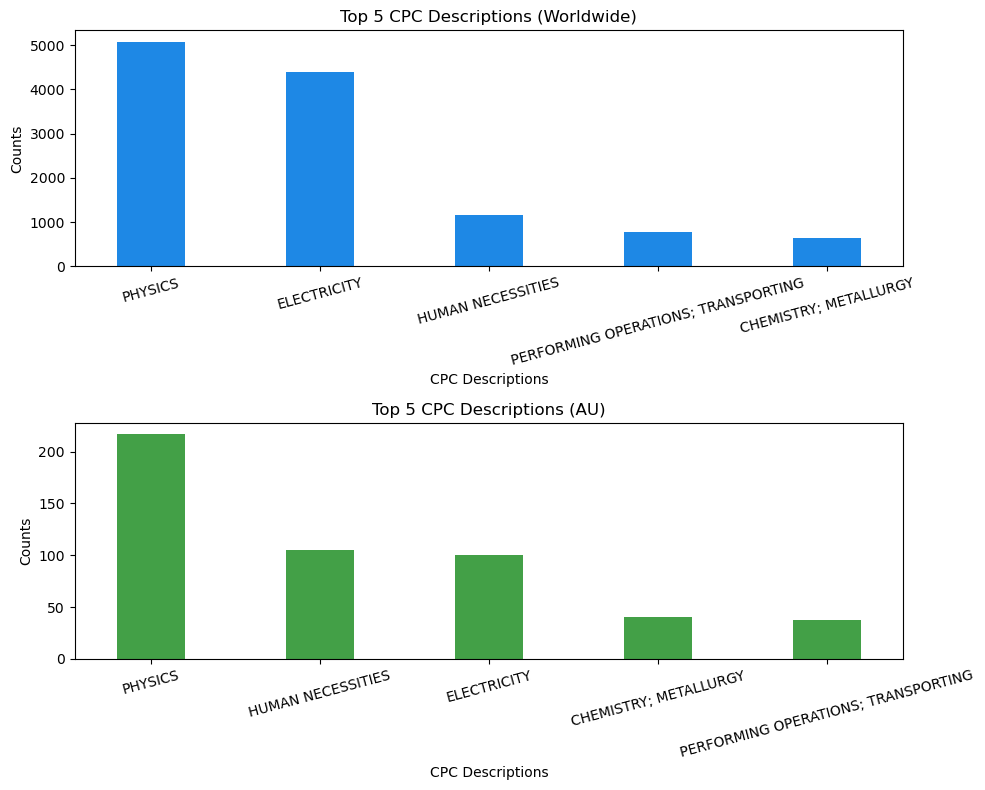

In [78]:
import matplotlib.pyplot as plt

# Create subset for AU jurisdiction
df_clean_au = df_clean[df_clean['jurisdiction'] == 'AU']

# Get top 5 CPC descriptions for worldwide data
worldwide_counts = df_clean['cpc_description'].value_counts().head(5)

# Get top 5 CPC descriptions for AU data
au_counts = df_clean_au['cpc_description'].value_counts().head(5)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotting the worldwide data
worldwide_counts.plot(kind='bar', ax=ax1, color='#1E88E5', width=0.4) # Adjusted width to make bars thinner
ax1.set_title("Top 5 CPC Descriptions (Worldwide)")
ax1.set_xlabel("CPC Descriptions")
ax1.set_ylabel("Counts")
ax1.tick_params(axis='x', rotation=15)  # Rotate x labels for better visibility

# Plotting the AU data
au_counts.plot(kind='bar', ax=ax2, color='#43A047', width=0.4) # Adjusted width to make bars thinner
ax2.set_title("Top 5 CPC Descriptions (AU)")
ax2.set_xlabel("CPC Descriptions")
ax2.set_ylabel("Counts")
ax2.tick_params(axis='x', rotation=15)  # Rotate x labels for better visibility

plt.tight_layout()
plt.show()


In [51]:
df_clean['biblio_classifications_cpc_symbols'].head()

0    [nan]
1    [nan]
2    [nan]
3    [nan]
4    [nan]
Name: biblio_classifications_cpc_symbols, dtype: object

# Citation Analysis

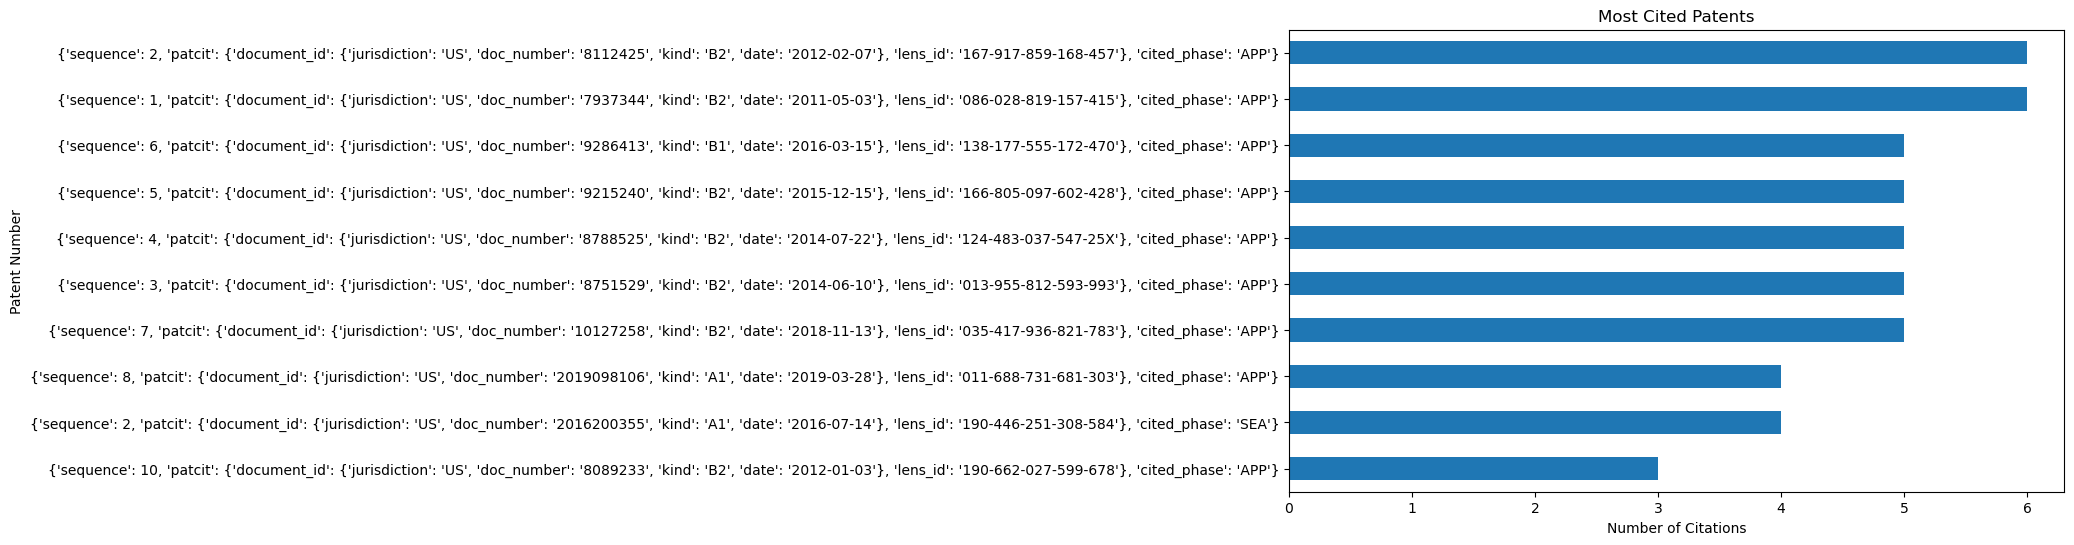

In [49]:
df_clean.explode('biblio_references_cited_citations')['biblio_references_cited_citations'].value_counts().head(10).plot(kind='barh', figsize=(10,6))
plt.title('Most Cited Patents')
plt.xlabel('Number of Citations')
plt.ylabel('Patent Number')
plt.gca().invert_yaxis()
plt.show()


# Sentiment Analysis

C:\Users\justi\AppData\Local\Temp\ipykernel_45136\4251696819.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_clean['sentiment'], bins=30)


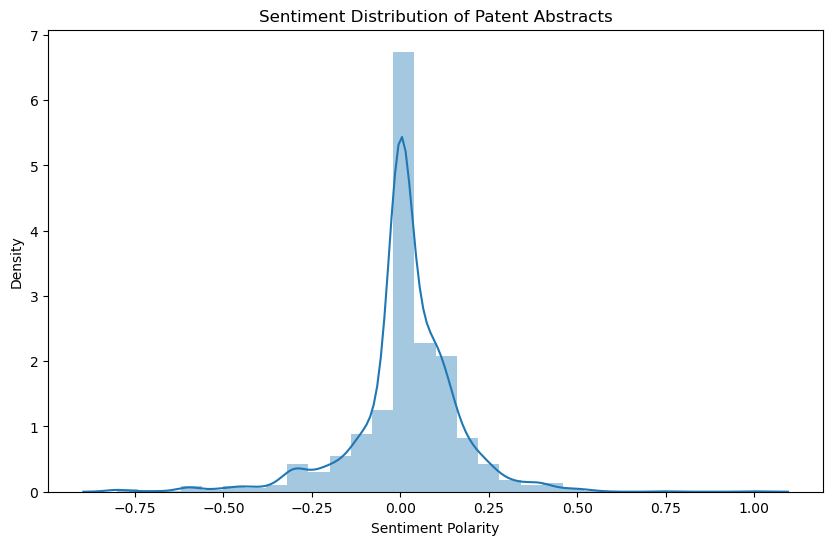

In [50]:
from textblob import TextBlob

# Function to get the polarity of text
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply the function to the abstracts
df_clean['sentiment'] = df_clean['abstract_text'].apply(get_sentiment)

# Visualize the sentiment distribution
plt.figure(figsize=(10,6))
sns.distplot(df_clean['sentiment'], bins=30)
plt.title('Sentiment Distribution of Patent Abstracts')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Density')
plt.show()


In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate an XGBoost classifier object
model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1
)

# Fit the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
